In [1]:
from __future__ import print_function
from builtins import super
"""
Implementation of Block Neural Autoregressive Flow
http://arxiv.org/abs/1904.04676
"""
import torch.nn.functional as F
import random
import torch
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "0" 
torch.set_printoptions(profile="full")
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import warnings
import torchvision
print ("torch",torch.__version__)
print ("torchvision",torchvision.__version__)
warnings.filterwarnings("ignore")
import pandas as pd 
import sys
from IPython.display import clear_output

import array
import math
import os
import time
import argparse
import pprint
from functools import partial
import json
%matplotlib inline

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)

import csv
from torch.utils import data
from tqdm import trange
#fig, axs = plt.subplots(2,2)
#plt.plot([1,2],[2,1])
#plt.show()


torch 1.8.1+cu102
torchvision 0.9.1+cu102


In [2]:
def freezelayer(child):
  for param in child.parameters():
     param.requires_grad = False
def releaselayer(child):
  for param in child.parameters():
     param.requires_grad = True


def expand_array(images,ncol=1,tosum=False):
  Nimages=len(images)
  ncolors=ncol
  npix=32
  shift=(37-npix)/2
  arrsize=1
  popind=[]
  if not tosum:
    arrsize=ncolors
  expandedimages=np.zeros((Nimages,npix,npix,arrsize),dtype=np.float32)
  for i in range(Nimages):
    npart = len(images[i])
    for j in range(npart):
       if tosum:
               expandedimages[i,images[i][j][0][0],images[i][j][0][1]][0]=0.0
               for nn in range(ncolors):
                   #print(expandedimages[i,images[i][j][0][0],images[i][j][0][1]])
                   expandedimages[i,images[i][j][0][0],images[i][j][0][1]][0] += images[i][j][1][nn]
       else:
               for nn in range(ncolors):
                   if ((images[i][j][0][0]-shift)>=npix or (images[i][j][0][1]-shift)>=npix):
                        continue
                   if ((images[i][j][0][0]-shift)<0 or (images[i][j][0][1]-shift)<0):
                        continue
                   expandedimages[i,int(images[i][j][0][0]-shift),int(images[i][j][0][1]-shift)][nn] = images[i][j][1][nn]
    #print("---")

    if expandedimages[i].sum()<0.9:
        pass
        #np.delete(expandedimages,i)
    else:
        popind.append(i)

        #print("---")
        expandedimages[i]=np.tanh(10*expandedimages[i])
        expandedimages[i]=expandedimages[i]/expandedimages[i].sum()
    #print(i)
  expandedimages=expandedimages.reshape(Nimages,arrsize,npix,npix)
  return expandedimages[popind]

In [3]:

# --------------------
# Data
# --------------------

datamap=        {
                #'qcd':"/cms/knash/EOS/JetImages/kevin/qcdls.dat",
                'qcd':"/cms/knash/EOS/JetImages/kevin/decorrtritopv142017/QCDv142017allstd_shuftritopconstpt.dat",
                'qcdtest':"/cms/knash/EOS/decorrtritopv142017/QCDv142017allstd_shuftritopconstpt.dat",
                #'ttbar':"/cms/knash/EOS/JetImages/kevin/ttLS.dat",
                'ttbar':"/cms/knash/EOS/JetImages/kevin/decorrtritopv142017/ZPv142017allstd_shuftritopconstpt.dat",
                'shihqcd':"/cms/daj111/autoencoder/datafiles/shihfiles/train_QCD_1800k.dat",
                'shihqcdtest':"/cms/daj111/autoencoder/datafiles/shihfiles/test_QCD_200k.dat",
                'shihttbar':"/cms/daj111/autoencoder/datafiles/shihfiles/train_TOPS_70k.dat",
                'shihttbartest':"/cms/daj111/autoencoder/datafiles/shihfiles/test_TOPS_15k.dat",
                'shihglu':"/cms/daj111/autoencoder/datafiles/shihfiles/test_GLUI_200k.dat"
                }
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

class sample_2d_data:
    def __init__(self,dataset, n_samples, ntot_samples,ncol=1,tosum=False,firstev=0):


        self.dataset=dataset
        self.nepoch=0
        self.glos=0
        self.jsonsamp=None
        self.ntot_samples=ntot_samples
        self.n_samples=n_samples


        self.fileb=dataset


        ebit=False
        self.jsonsamp=(json.loads(s) for s in open(self.fileb))
        x_val=[]
        print("Populating...")
        for isamp in range(firstev): 
            next(self.jsonsamp)

        for iii in range(ntot_samples): 
            if (iii%10000)==0:
              print("Event",iii,"of",ntot_samples)
            xy=next(self.jsonsamp)
            x_val.append(xy[0])

        x_val=np.array(x_val)

        exparr=expand_array(x_val,ncol,tosum)
        exparr=np.array(exparr,dtype=np.float32)
        self.jsonsamp=torch.from_numpy(exparr)
        self.totsamp=len(self.jsonsamp)
        
    def sreturn(self):

        if (self.glos+self.n_samples>self.totsamp):
          print("SHUFFLE")
          self.jsonsamp = self.jsonsamp[torch.randperm(self.totsamp)]
          self.glos=0
          self.nepoch+=1
          ebit=True

        toreturn=self.jsonsamp[self.glos:self.glos+self.n_samples]
        self.glos+=self.n_samples
        
        return (toreturn)



In [4]:


nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 32


ngf = 32
ndf = 32
nzf = 32

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf , ndf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

    
class PreProc(nn.Module):
    def __init__(self):
        super(PreProc, self).__init__()
        self.L1 = nn.Linear(in_features=nz, out_features=nz)
        self.BN = nn.LayerNorm(nz)


    def forward(self, input):
        ishape=input.shape
        PRE= input.reshape(input.size(0),input.size(1))
        #print(nz,PRE.shape)
        
        PRE= self.L1(PRE)
        PRE= self.BN(PRE)
        return F.relu(PRE.reshape(ishape))
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf*1, nc, 4, 2, 1, bias=False),
            nn.ReLU(True),
        )
        self.L1 = nn.Linear(in_features=nz, out_features=(ngf*4)*4*4)



    def forward(self, input):
        #GEN=F.dropout(input,0.5)
        #GEN=F.dropout(input,0.5)

        GEN=self.main(input)
        shape=GEN.shape
        GEN = F.softmax(GEN.reshape(GEN.size(0), -1))
        GEN = GEN.view(shape)  
        return GEN
    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, nzf, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(p=0.5, inplace=True),
            nn.Conv2d(nzf , nzf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(nzf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(p=0.5, inplace=True),
            nn.Conv2d(nzf * 2, nzf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(nzf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(p=0.5, inplace=True),
            nn.Conv2d(nzf * 4, nz , 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Tanh()
        )
        self.L1 = nn.Sequential(
            nn.Linear(in_features=nzf * 4 * 16, out_features=nzf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=nzf*8, out_features=nz),
            nn.Tanh())

    def forward(self, input):
        
        ENC=self.main(input)
        #print(ENC.shape)
        #ENC=ENC.reshape(ENC.size(0),-1)
        #print(ENC.shape,nz)
        #ENC=self.L1(ENC)
        #print(ENC.shape)

        return (ENC.reshape(ENC.size(0),-1, 1,1))
    
 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [5]:
def minmax(img):

    MMimg=(img-img.amin())/(img.amax()-img.amin())
    return (MMimg)
def train_flow(model, datagens, curHparams):


        
        
    n_steps=curHparams.n_steps
    n_tot=curHparams.n_tot
    batch_size=curHparams.batch_size
    
    BCEcriterion = nn.BCELoss()
    MSEcriterion = nn.MSELoss()
    L1criterion = nn.L1Loss()
    #MSEcriterionval = nn.MSELoss(reduce=False)
    MSEcriterionval = nn.MSELoss(reduce=False)

    #MSEcriterionval = nn.MSELoss()


    DEmodeltrain,DISCmodeltrain,ENCmodeltrain,PreProcmodeltrain=model

    lr=0.00003
    
    
    DEoptimizer = torch.optim.Adam(DEmodeltrain.parameters(), lr=4*lr, betas=(0.5, 0.999))
    DISCoptimizer = torch.optim.Adam(DISCmodeltrain.parameters(), lr=lr, betas=(0.5, 0.999))
    ENCoptimizer = torch.optim.Adam(ENCmodeltrain.parameters(), lr=0.0005, betas=(0.5, 0.999))
    PreProcoptimizer = torch.optim.Adam(PreProcmodeltrain.parameters(), lr=0.00001, betas=(0.5, 0.999))

    
    #DElrshed=torch.optim.lr_scheduler.ReduceLROnPlateau(DEoptimizer, factor=0.99,patience=5, verbose=True)
    #DISClrshed=torch.optim.lr_scheduler.ReduceLROnPlateau(DISCoptimizer, factor=0.99,patience=5, verbose=True)
    DElrshed=torch.optim.lr_scheduler.StepLR(DEoptimizer,  step_size=5, gamma=0.7, verbose=True)
    DISClrshed=torch.optim.lr_scheduler.StepLR(DISCoptimizer,  step_size=5, gamma=0.7, verbose=True)
    ENClrshed=torch.optim.lr_scheduler.StepLR(ENCoptimizer,  step_size=5, gamma=0.7, verbose=True)

    

    DEmodeltrain.train()
    DISCmodeltrain.train()
    ENCmodeltrain.train()
    PreProcmodeltrain.train()

    latent_dim=curHparams.data_dim
    print (curHparams.cuda)
    step=0
    nepoch=0
    lossDEmean=0.0
    lossDISCmean=0.0
    lossENCmean=0.0

    lossDEepoch=[]
    lossDISCepoch=[]
    lossENCepoch=[]
    #DElrshed=torch.optim.lr_scheduler.StepLR(DEoptimizer, 3, gamma=0.5, last_epoch=-1, verbose=True)
    #DElrshed=torch.optim.lr_scheduler.ReduceLROnPlateau(DEoptimizer, factor=0.9,patience=1, verbose=True)
    #DISClrshed=torch.optim.lr_scheduler.ReduceLROnPlateau(DISCoptimizer, factor=0.9,patience=1, verbose=True)
    [fulltrain,fullval,fullsig] = datagens
    stepsperepoch=int(float(n_tot)/float(batch_size))
    zdim=nz
    with tqdm(total=n_steps, desc='Start step {}; Training for {} steps'.format(step, n_steps)) as pbar:
        for _ in range(n_steps):
            Z = torch.normal(0, 1, size=(batch_size,zdim ,1,1)).to('cuda:'+str(curHparams.cuda))
            
            
            
            
            
            
            
            
            
            
            
            
                
                
            Z = PreProcmodeltrain(Z)
            Zdisttrain = Z.norm(dim=(1,2)).squeeze()
            #truepre=torch.zeros(batch_size,nz).to('cuda:'+str(curHparams.cuda))
            #ealpre=Z.reshape(batch_size,nz).to('cuda:'+str(curHparams.cuda))
            
            
            
            
            
            
            
            
            
            
            
            
            
            Realimg = fulltrain.sreturn().to('cuda:'+str(curHparams.cuda))
            Fakeimg = DEmodeltrain(Z)


            
            
            TrainReal=Realimg
            TrainFake=Fakeimg.to('cuda:'+str(curHparams.cuda))

            TrueReal=(torch.ones(batch_size).to('cuda:'+str(curHparams.cuda)))
            TrueFake=(torch.zeros(batch_size).to('cuda:'+str(curHparams.cuda)))
            
            DISCoptimizer.zero_grad()
            DiscReal=DISCmodeltrain(TrainReal).view(-1)
            DiscFake=DISCmodeltrain(TrainFake.detach()).view(-1)
            BCER=BCEcriterion(DiscReal,TrueReal)
            BCEF=BCEcriterion(DiscFake,TrueFake)
            #preloss=BCEcriterion(realpre,truepre)
            #print (realpre.shape,truepre.shape)


            
            
            DISCloss=(BCER+BCEF)/2.0
            BCER.backward()
            BCEF.backward()
            DISCoptimizer.step()


            
            DEmodeltrain.zero_grad()
            ENCoptimizer.zero_grad()
            PreProcoptimizer.zero_grad()

            
            

            fake_X = DEmodeltrain(Z).to('cuda:'+str(curHparams.cuda))
            fake_Y = DISCmodeltrain(fake_X).squeeze()
            ones = torch.ones((batch_size,), device=Z.device)
            DEloss = BCEcriterion(fake_Y, ones.reshape(fake_Y.shape))
                        
            
            
            pbar.update()
 

            enc=ENCmodeltrain(fake_X)         
            ReencFakeimg=DEmodeltrain(enc)
            Zloss=L1criterion(ReencFakeimg,fake_X)
            
            #enc=ENCmodeltrain(Realimg)         
            #ReencFakeimg=DEmodeltrain(enc)
            #Zloss=L1criterion(ReencFakeimg,Realimg)
            
            Zloss1=L1criterion(Z,enc)
            #Zloss+=DEloss
            Zdisttrain.abs().mean().backward(retain_graph=True)
            #print(Zdisttrain.mean())
            DEloss.backward(retain_graph=True)
            Zloss.backward()

            pbar.set_postfix(DISCloss='{:.4f}'.format(DISCloss),DEloss='{:.4f}'.format(DEloss),Zloss='{:.4f}'.format(Zloss))
            
            ENCoptimizer.step()
            DEoptimizer.step()
            PreProcoptimizer.step()
            
            lossDEmean += DEloss.cpu().detach().numpy()
            lossDISCmean += DISCloss.cpu().detach().numpy()
            lossENCmean += Zloss.cpu().detach().numpy()


            if ((step%stepsperepoch==0) and (step>1)):
                print("epoch",nepoch)
                

                DEmodeltrain.eval()
                DISCmodeltrain.eval()
                ENCmodeltrain.eval()
                
                Z = torch.normal(0, 1, size=(fullval.n_samples,zdim ,1,1)).to('cuda:'+str(curHparams.cuda))
                
                
                
                
                
                
                
                
                Z = PreProcmodeltrain(Z)
                print (Z)
                
                
                
                
                
                
                
                
                
                RealimgVal = fullval.sreturn().to('cuda:'+str(curHparams.cuda))
                FakeimgVal = DEmodeltrain(Z)
                RealimgSig = fullsig.sreturn().to('cuda:'+str(curHparams.cuda))
                


                Fakeenc=ENCmodeltrain(FakeimgVal)
                Realenc=ENCmodeltrain(RealimgVal)
                Sigenc=ENCmodeltrain(RealimgSig)
                
                ZdistRealimgVal = -1.*(Realenc).norm(dim=(1,2)).squeeze()
                ZdistFakeimgVal = -1.*(Fakeenc).norm(dim=(1,2)).squeeze()
                ZdistRealimgSig = -1.*(Sigenc).norm(dim=(1,2)).squeeze() 
                lam=0.999
                
                ReencFakeimg=DEmodeltrain(Fakeenc)
                ReencRealimg=DEmodeltrain(Realenc)
                ReencSigimg=DEmodeltrain(Sigenc)
                clear_output(wait=True)
                print("DIST",ZdistRealimgVal.shape)
                
                #ReencFakeimg=(ReencFakeimg-ReencFakeimg.amin())/(ReencFakeimg.amax()-ReencFakeimg.amin())
                #FakeimgVal=(FakeimgVal-FakeimgVal.amin())/(FakeimgVal.amax()-FakeimgVal.amin())
                #ReencSigimg=(ReencSigimg-ReencSigimg.amin())/(ReencSigimg.amax()-ReencSigimg.amin())
                #RealimgSig=(RealimgSig-RealimgSig.amin()/(RealimgSig.amax()-RealimgSig.amin()))
    
                
                ZlossValFake=MSEcriterionval(minmax(ReencFakeimg),minmax(FakeimgVal.detach()))#/(ReencFakeimg+FakeimgVal.detach())
                ZlossValReal=MSEcriterionval(minmax(ReencRealimg),minmax(RealimgVal.detach()))#/(ReencRealimg+RealimgVal.detach())
                ZlossValSig=MSEcriterionval(minmax(ReencSigimg),minmax(RealimgSig.detach()))#/(ReencSigimg+RealimgSig.detach())


                
                #valdiscZN=(1.-lam)*(1.0/math.sqrt(Z.numel()))*ZdistRealimgVal
                #fakediscZN=(1.-lam)*(1.0/math.sqrt(Z.numel()))*ZdistFakeimgVal
                #sigdiscZN=(1.-lam)*(1.0/math.sqrt(Z.numel()))*ZdistRealimgSig
                #valdiscMSE = ((lam)*(1.0/ZlossValReal.numel())*ZlossValReal.mean(dim=(1,2,3)))
                #fakediscMSE = ((lam)*(1.0/ZlossValFake.numel())*ZlossValFake.mean(dim=(1,2,3)))
                #sigdiscMSE = ((lam)*(1.0/ZlossValSig.numel())*ZlossValSig.mean(dim=(1,2,3)))
                                
                
                valdiscZN=(1.-lam)*ZdistRealimgVal
                fakediscZN=(1.-lam)*ZdistFakeimgVal
                sigdiscZN=(1.-lam)*ZdistRealimgSig
                
                valdiscMSE = ((lam)*ZlossValReal.mean(dim=(1,2,3)))
                fakediscMSE = ((lam)*ZlossValFake.mean(dim=(1,2,3)))
                sigdiscMSE = ((lam)*ZlossValSig.mean(dim=(1,2,3)))
                

                divvalfake=((FakeimgVal>10e-8).sum(dim=(1,2,3)))
                divvalreal=((RealimgVal>10e-8).sum(dim=(1,2,3)))
                divvalsig=((RealimgSig>10e-8).sum(dim=(1,2,3)))
                
                print("aaa")
                print(divvalsig.sum()/float(divvalsig.numel()))
                print("bbb")
                print(divvalreal.sum()/float(divvalreal.numel()))
                
                #valdiscMSE/=divvalreal
                #fakediscMSE/=divvalfake 
                #sigdiscMSE/=divvalsig

                
                #valdiscMSE=valdiscMSE.mean()
                #fakediscMSE=fakediscMSE.mean()
                #sigdiscMSE=sigdiscMSE.mean()
                
                fakedisc=(fakediscZN+fakediscMSE)
                valdisc=(valdiscZN+valdiscMSE)
                sigdisc=(sigdiscZN+sigdiscMSE)
                

                print("FracMSE",((valdiscMSE)/(valdiscZN+valdiscMSE)).mean())
                print("FracZN",((valdiscZN)/(valdiscZN+valdiscMSE)).mean())

                nepoch+=1
                lossDEepoch.append(lossDEmean/float(stepsperepoch))
                lossDISCepoch.append(lossDISCmean/float(stepsperepoch))  
                
                lossENCepoch.append(lossENCmean/float(stepsperepoch))


                print ("ZlossValFake",fakedisc.mean())
                print ("ZlossValReal",valdisc.mean())
                print ("ZlossValSig",sigdisc.mean())

                print("REALSHAPE",RealimgVal.shape)
                print("FAKESHAPE",FakeimgVal.shape)
                print("FAKESHAPE",RealimgSig.shape)
                fig, axs = plt.subplots(8,4)
                fig.set_figheight(25)
                fig.set_figwidth(25)
                print ("REALINT",torch.abs(torch.sum(RealimgVal)))
                print ("FAKEINT",torch.abs(torch.sum(FakeimgVal)))
                print ("SIGINT",torch.abs(torch.sum(RealimgSig)))
                #print (Z)
                #print (Realenc[1])
                #print (Fakeenc[1])
                print("Plot1")
                axs[0][0].imshow(torch.abs(torch.sum(RealimgVal,dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))

                print("Plot2")
                axs[1][0].imshow(torch.abs(torch.sum(FakeimgVal,dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                
                #axs[2][0].imshow(torch.abs(torch.sum(ReencRealimg[1],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                #axs[2][1].imshow(torch.abs(torch.sum(Realimg[1],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[2][0].imshow(torch.abs(torch.sum(ReencRealimg[0],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[2][1].imshow(torch.abs(torch.sum(RealimgVal[0],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))

                axs[2][2].imshow(torch.abs(torch.sum(ReencRealimg[1],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[2][3].imshow(torch.abs(torch.sum(RealimgVal[1],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                
                axs[3][0].imshow(torch.abs(torch.sum(ReencRealimg[2],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[3][1].imshow(torch.abs(torch.sum(RealimgVal[2],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))

                axs[3][2].imshow(torch.abs(torch.sum(ReencRealimg[3],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[3][3].imshow(torch.abs(torch.sum(RealimgVal[3],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))

                
                
                axs[4][0].imshow(torch.abs(torch.sum(ReencFakeimg[0],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[4][1].imshow(torch.abs(torch.sum(FakeimgVal[0],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))

                axs[4][2].imshow(torch.abs(torch.sum(ReencFakeimg[1],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[4][3].imshow(torch.abs(torch.sum(FakeimgVal[1],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                
                axs[5][0].imshow(torch.abs(torch.sum(ReencFakeimg[2],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[5][1].imshow(torch.abs(torch.sum(FakeimgVal[2],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))

                axs[5][2].imshow(torch.abs(torch.sum(ReencFakeimg[3],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[5][3].imshow(torch.abs(torch.sum(FakeimgVal[3],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                
                
                
                
                axs[6][0].imshow(torch.abs(torch.sum(ReencSigimg[0],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[6][1].imshow(torch.abs(torch.sum(RealimgSig[0],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))

                axs[6][2].imshow(torch.abs(torch.sum(ReencSigimg[1],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[6][3].imshow(torch.abs(torch.sum(RealimgSig[1],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                
                axs[7][0].imshow(torch.abs(torch.sum(ReencSigimg[2],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[7][1].imshow(torch.abs(torch.sum(RealimgSig[2],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))

                axs[7][2].imshow(torch.abs(torch.sum(ReencSigimg[3],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))
                axs[7][3].imshow(torch.abs(torch.sum(RealimgSig[3],dim=0)+10e-10).cpu().detach().numpy().reshape(32,32))

                print("Plot3")
                DEline = axs[0][1].plot(lossDEepoch)
                DISCline = axs[0][1].plot(lossDISCepoch)
                #DEline.set_label('Generator loss')
                #DISCline.set_label('Discriminator loss')
                print("Plot4")
                ENCLossline = axs[0][2].plot(lossENCepoch)


                
                print("Plot5")
                print(torch.abs(valdisc).cpu().detach().numpy().sum())
                print(torch.abs(sigdisc).cpu().detach().numpy().sum())
                
                minbin=min(torch.abs(valdiscZN).min(),torch.abs(sigdiscZN).min(),torch.abs(fakediscZN).min()).cpu().detach().numpy()*0.8
                maxbin=max(torch.abs(valdiscZN).max(),torch.abs(sigdiscZN).max(),torch.abs(fakediscZN).max()).cpu().detach().numpy()*1.2
                bkgline = axs[1][1].hist(torch.abs(valdiscZN).cpu().detach().numpy(),bins=100,range=[minbin,maxbin],alpha=0.5,color="red")
                sigline = axs[1][1].hist(torch.abs(sigdiscZN).cpu().detach().numpy(),bins=100,range=[minbin,maxbin],alpha=0.5,color="blue") 
                fakeline = axs[1][1].hist(torch.abs(fakediscZN).cpu().detach().numpy(),bins=100,range=[minbin,maxbin],alpha=0.5,color="green")
            
                minbin=min(torch.abs(valdiscMSE).min(),torch.abs(sigdiscMSE).min(),torch.abs(fakediscMSE).min()).cpu().detach().numpy()*0.8
                maxbin=max(torch.abs(valdiscMSE).max(),torch.abs(sigdiscMSE).max(),torch.abs(fakediscMSE).max()).cpu().detach().numpy()*1.2
                bkglineMSE = axs[1][2].hist(torch.abs(valdiscMSE).cpu().detach().numpy(),bins=100,range=[minbin,maxbin],alpha=0.5,color="red")
                siglineMSE = axs[1][2].hist(torch.abs(sigdiscMSE).cpu().detach().numpy(),bins=100,range=[minbin,maxbin],alpha=0.5,color="blue") 
                fakelineMSE = axs[1][2].hist(torch.abs(fakediscMSE).cpu().detach().numpy(),bins=100,range=[minbin,maxbin],alpha=0.5,color="green")
                print ("TWODISCS",fakediscMSE.mean(),fakediscZN.mean(),fakedisc.mean())
                print ("TWODISCS",sigdiscMSE.mean(),sigdiscZN.mean(),sigdisc.mean())
                print ("TWODISCS",valdiscMSE.mean(),valdiscZN.mean(),valdisc.mean())
                
         
                
                minbin=min(torch.abs(valdisc).min(),torch.abs(sigdisc).min(),torch.abs(fakedisc).min()).cpu().detach().numpy()*0.8
                maxbin=max(torch.abs(valdisc).max(),torch.abs(sigdisc).max(),torch.abs(fakedisc).max()).cpu().detach().numpy()*1.2
                bkglinecomb = axs[1][3].hist(torch.abs(valdisc).cpu().detach().numpy(),bins=100,range=[minbin,maxbin],alpha=0.5,color="red")
                siglinecomb = axs[1][3].hist(torch.abs(sigdisc).cpu().detach().numpy(),bins=100,range=[minbin,maxbin],alpha=0.5,color="blue") 
                fakelinecomb = axs[1][3].hist(torch.abs(fakedisc).cpu().detach().numpy(),bins=100,range=[minbin,maxbin],alpha=0.5,color="green")                
                
                #bkgline.set_label('Background')
                #sigline.set_label('Signal')
                
                matplotlib.pyplot.show()

                plt.pause(0.0001)
                lossDEmean = 0.0
                lossDISCmean = 0.0    
                lossENCmean = 0.0    

                DEmodeltrain.train()
                DISCmodeltrain.train()
                ENCmodeltrain.train()

                #DElrshed.step(DEloss )
                #DISClrshed.step(DISCloss )
                DElrshed.step()
                DISClrshed.step()            
                ENClrshed.step()          
            step+=1
            

DIST torch.Size([1886])
aaa
tensor(34.3690, device='cuda:0')
bbb
tensor(46.8468, device='cuda:0')
FracMSE tensor(-0.4969, device='cuda:0', grad_fn=<MeanBackward0>)
FracZN tensor(1.4969, device='cuda:0', grad_fn=<MeanBackward0>)
ZlossValFake tensor(-0.0017, device='cuda:0', grad_fn=<MeanBackward0>)
ZlossValReal tensor(-0.0016, device='cuda:0', grad_fn=<MeanBackward0>)
ZlossValSig tensor(-0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
REALSHAPE torch.Size([1886, 1, 32, 32])
FAKESHAPE torch.Size([2000, 1, 32, 32])
FAKESHAPE torch.Size([1965, 1, 32, 32])
REALINT tensor(1886., device='cuda:0')
FAKEINT tensor(2000., device='cuda:0', grad_fn=<AbsBackward>)
SIGINT tensor(1965., device='cuda:0')
Plot1
Plot2
Plot3
Plot4
Plot5
3.031765
3.9970694
TWODISCS tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-0.0025, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-0.0017, device='cuda:0', grad_fn=<MeanBackward0>)
TWODISCS tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>) tens

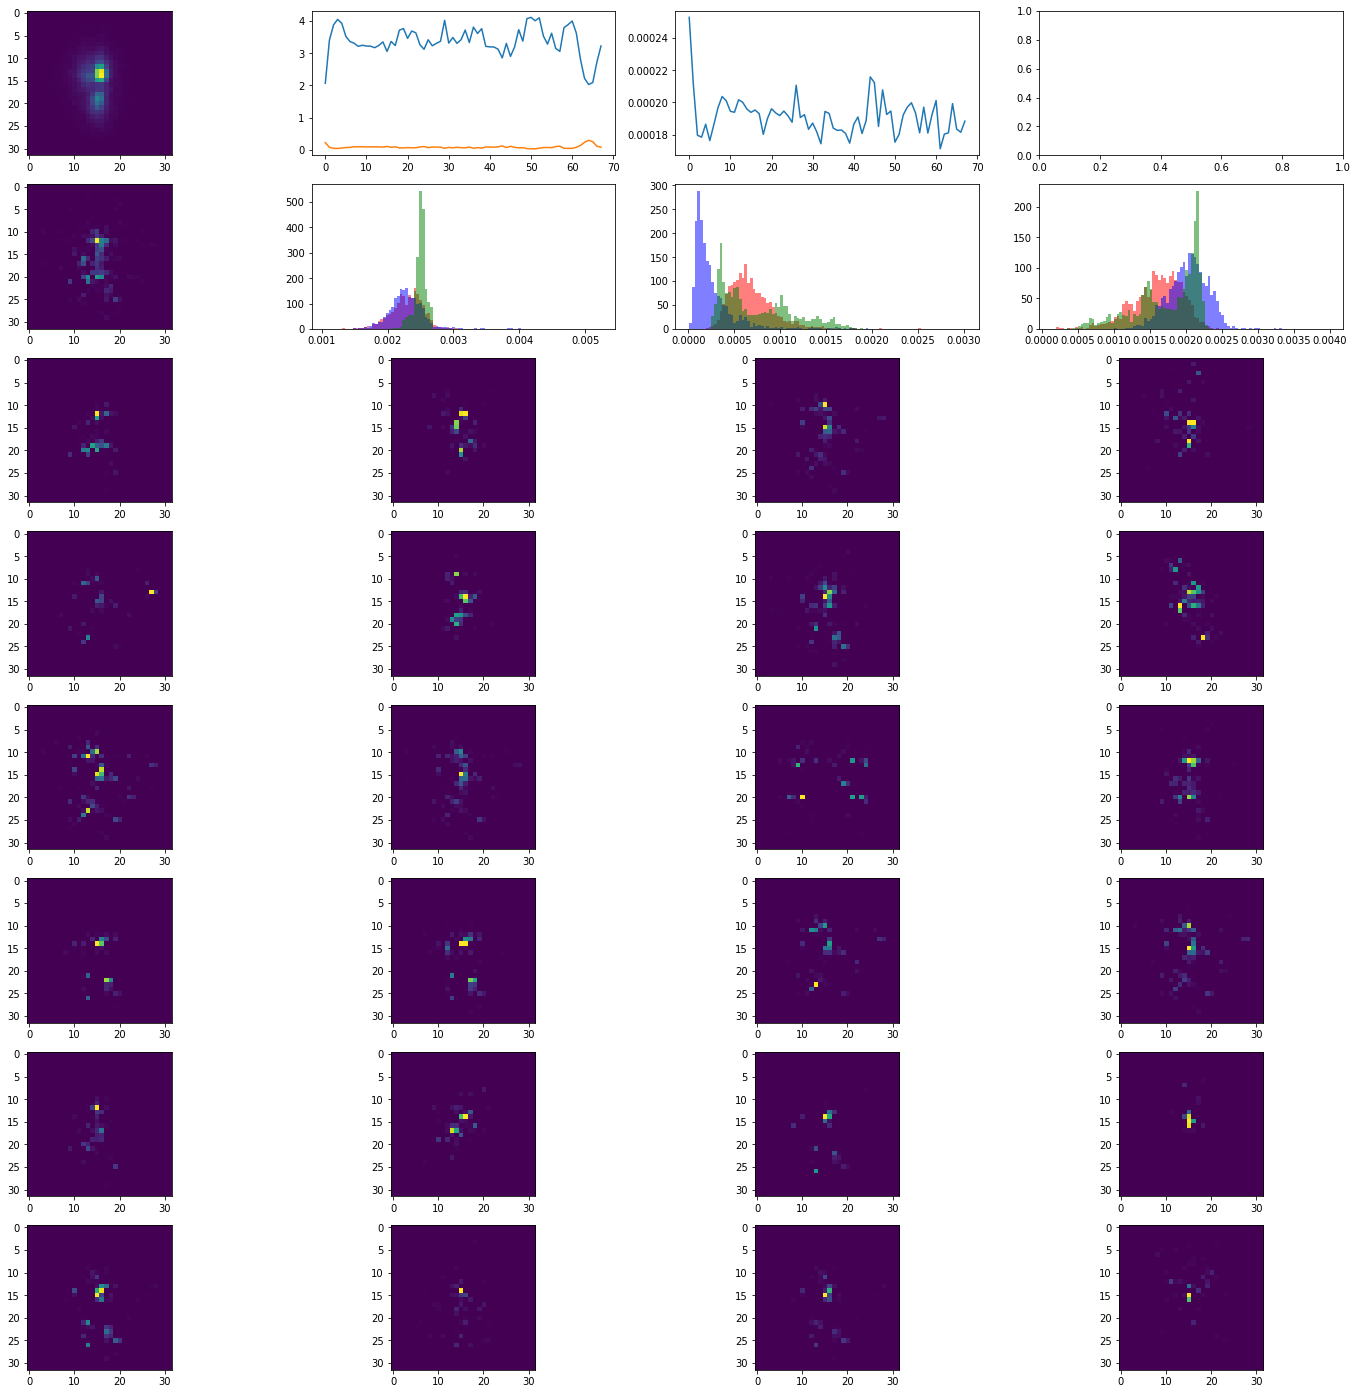

Start step 0; Training for 300000 steps:  99%|█████████▉| 297521/300000 [54:41<04:02, 10.24it/s, DEloss=2.2025, DISCloss=0.1489, Zloss=0.0001] 

Adjusting learning rate of group 0 to 1.1627e-06.
Adjusting learning rate of group 0 to 2.9067e-07.
Adjusting learning rate of group 0 to 4.8445e-06.


Start step 0; Training for 300000 steps: 100%|██████████| 300000/300000 [55:05<00:00, 90.75it/s, DEloss=3.9429, DISCloss=0.0571, Zloss=0.0002] 


In [6]:


class Hparams():
    def __init__(self):    
        self.ncol=1
        self.data_dim=64
        self.n_hidden=128
        self.hidden_dim=1
        self.batch_size=16
        self.n_steps=300000
        self.n_tot=70000
        
        self.n_val=2000
        self.dataset="shihqcd"
        self.datasetval="shihqcdtest"
        self.datasetsig="shihttbartest"

        self.tosum=False
        self.cuda=0
    
curHparams=Hparams()

curHparams.dataset="ttbar"
curHparams.datasetval="ttbar"
curHparams.datasetsig="qcd"

#curHparams.dataset="qcd"
#curHparams.datasetval="qcd"
#curHparams.datasetsig="ttbar"

if not curHparams.tosum:
    AEsize=curHparams.ncol
    
DEmodel = Decoder().to('cuda:'+str(curHparams.cuda))
DISCmodel = Discriminator().to('cuda:'+str(curHparams.cuda))
ENCmodel = Encoder().to('cuda:'+str(curHparams.cuda))
PreProcmodel = PreProc().to('cuda:'+str(curHparams.cuda))


fulltrain = sample_2d_data(datamap[curHparams.dataset],curHparams.batch_size,curHparams.n_tot,ncol=curHparams.ncol,tosum=curHparams.tosum,firstev=curHparams.n_val)
fullval = sample_2d_data(datamap[curHparams.datasetval],curHparams.n_val,curHparams.n_val,ncol=curHparams.ncol,tosum=curHparams.tosum,firstev=0)
fullsig = sample_2d_data(datamap[curHparams.datasetsig],curHparams.n_val,curHparams.n_val,ncol=curHparams.ncol,tosum=curHparams.tosum,firstev=0)

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t,r,a)

        
        
DEmodel.apply(weights_init)
DISCmodel.apply(weights_init)

ENCmodel.apply(weights_init)
PreProcmodel.apply(weights_init)

torch.cuda.empty_cache()


train_flow([DEmodel,DISCmodel,ENCmodel,PreProcmodel], [fulltrain,fullval,fullsig], curHparams)



